In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [2]:
feature_names = ['age','workclass','fnlwgt','education','education_num', 'marital_status','occupation',
                'relationship','race','sex','cap_gain','cap_loss','hrs_per_week','native_country','income']
df = pd.read_csv('adult.csv', header=None, names= feature_names)

df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hrs_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  cap_gain        32561 non-null  int64 
 11  cap_loss        32561 non-null  int64 
 12  hrs_per_week    32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
df.describe()

,age,fnlwgt,education_num,cap_gain,cap_loss,hrs_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
df['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [6]:
def convert_label(text):
    if text == ' <=50K':
        return 1
    if text == ' >50K':
        return 0
    else:
        return "Error"

df['income'] = df['income'].apply(convert_label)

In [7]:
# Break Features down based upon type and seperate out label
numeric_features = ['age','fnlwgt','education_num', 'cap_gain', 'cap_loss', 'hrs_per_week']
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex',
                        'native_country']
label = ['income']

df_numeric = df[numeric_features]
df_categorical = df[categorical_features]

In [8]:
def check_unique_counts_categorical(df):
    print("Unique Records in each column:")
    for col in df:
        if df[col].dtypes == 'O':
            print(f"{col}: " + str(df[col].nunique()))

check_unique_counts_categorical(df_categorical)

Unique Records in each column:
workclass: 9
education: 16
marital_status: 7
occupation: 15
relationship: 6
race: 5
sex: 2
native_country: 42


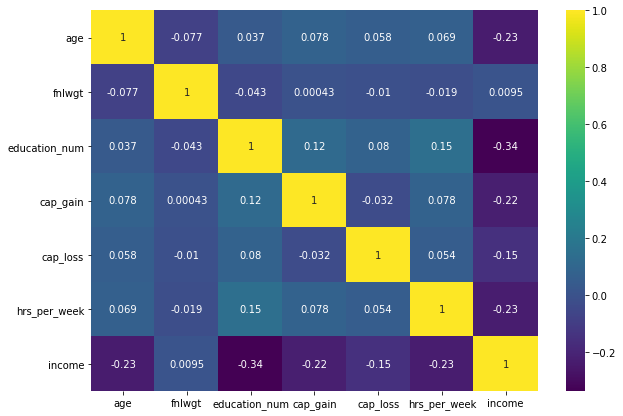

In [9]:
def correlation_summary(df):
    plt.figure(figsize=(10,7))
    sns.heatmap(df.corr(), annot=True, cmap='viridis')
    
correlation_summary(df)

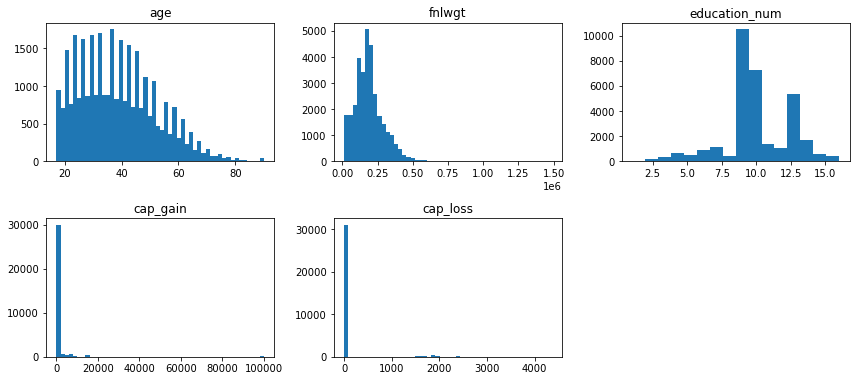

In [10]:
def plot_histograms_numeric_features(df, nrows, ncols):
    plt.figure(figsize=(12,6))
    for i in range(1, df.shape[1]):
        plt.subplot(nrows, ncols, i)
        f = plt.gca()
        f.set_title(df.columns.values[i-1])
    
        bin_num = np.size(df.iloc[:,i-1].unique())
        if bin_num > 20:
            plt.hist(df.iloc[:,i-1], bins= 50)
        else:
            plt.hist(df.iloc[:,i-1], bins= bin_num)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
plot_histograms_numeric_features(df_numeric,2,3)

# Preprocess Data

In [11]:
X = df.drop('income', axis=1)
y = df['income']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
ct= ColumnTransformer(transformers=
    [('Scale_numeric', StandardScaler(), numeric_features),
     ('one_hot', OneHotEncoder(sparse=False), categorical_features)])

In [13]:
X_train = ct.fit_transform(X_train)

In [14]:
X_train.shape

(26048, 108)

In [15]:
log_reg = LogisticRegression(max_iter=1000)
scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='f1')
print(scores)

[0.90181603 0.90618792 0.90552111]


In [16]:
model = log_reg.fit(X_train, y_train)

In [17]:
X_holdout = ct.transform(X_holdout)

y_pred = model.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1571
           1       0.88      0.94      0.91      4942

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513

[[ 967  604]
 [ 319 4623]]


In [18]:
clf_rf = RandomForestClassifier()
model = clf_rf.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

y_pred = model.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))
print(scores)

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1571
           1       0.89      0.93      0.91      4942

    accuracy                           0.86      6513
   macro avg       0.82      0.79      0.80      6513
weighted avg       0.85      0.86      0.86      6513

[[1010  561]
 [ 353 4589]]
[0.90014829 0.9052003  0.90460323 0.90922564 0.90803317]


In [19]:
clf_xg = XGBClassifier()
model = clf_xg.fit(X_train, y_train)
scores = cross_val_score(clf_xg, X_train, y_train, cv=5, scoring='f1')

y_pred = model.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))
print(scores)

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1571
           1       0.90      0.94      0.92      4942

    accuracy                           0.88      6513
   macro avg       0.84      0.81      0.82      6513
weighted avg       0.87      0.88      0.87      6513

[[1061  510]
 [ 291 4651]]
[0.91097411 0.91840796 0.91879293 0.91965389 0.91908586]


In [20]:
clf_svc = SVC()
model = clf_svc.fit(X_train, y_train)
scores = cross_val_score(clf_svc, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)

y_pred = model.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))
print(scores)

              precision    recall  f1-score   support

           0       0.77      0.60      0.68      1571
           1       0.88      0.94      0.91      4942

    accuracy                           0.86      6513
   macro avg       0.83      0.77      0.79      6513
weighted avg       0.86      0.86      0.85      6513

[[ 940  631]
 [ 273 4669]]
[0.90588923 0.90862759 0.90969212]


In [21]:
voting_clf = VotingClassifier(estimators=[('rf',clf_rf),
                                         ('xg',clf_xg),
                                         ('svm',clf_svc)],
                             voting='hard')

voting_clf.fit(X_train, y_train)
scores = cross_val_score(voting_clf, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)

y_pred = voting_clf.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))
print(scores)

              precision    recall  f1-score   support

           0       0.79      0.64      0.71      1571
           1       0.89      0.95      0.92      4942

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513

[[1006  565]
 [ 268 4674]]
[0.90898354 0.91557774 0.915494  ]


# try with a pipe

In [22]:
df['income'] = df['income'].apply(convert_label)
X = df.drop('income', axis=1)
y = df['income']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_holdout.shape

(6513, 14)

In [24]:
col_tranf= ColumnTransformer(transformers=
    [('Scale_numeric', StandardScaler(), numeric_features),
     ('one_hot', OneHotEncoder(sparse=False), categorical_features)])

In [25]:
num_pipeline= Pipeline([
    ('standard_scaler', StandardScaler())
    ])

cat_pipeline= Pipeline([
    ('one_hot', OneHotEncoder(sparse=False))
    ])

full_pipeline = (ColumnTransformer([
    ('numeric', num_pipeline, numeric_features),
    ('categorical', cat_pipeline, categorical_features)
])

SyntaxError: unexpected EOF while parsing (<ipython-input-25-7b4e5a6bce2b>, line 12)

In [ ]:
X_transformed = full_pipeline.fit_transform(X_train)
X_holdout_transformed = full_pipeline.transform(X_holdout)

In [ ]:
print(X_transformed.shape)
print(X_holdout_transformed.shape)

In [ ]:
rf_clf = RandomForestClassifier()

model = rf_clf.fit(X_transformed, y_train)
scores = cross_val_score(rf_clf, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
y_pred = model.predict(X_holdout_transformed)

print(classification_report(y_holdout, y_pred))
print(confusion_matrix(y_holdout, y_pred))
print(scores)

In [ ]:
scores = c